<center> <font size="6"> <div class="alert alert-block alert-success"> <strong> A2Z Insurance Customer Segmentation Project 
</strong> </div> </font> </center>

<center> <font size="4"> <div class="alert alert-block alert-success"> <strong> K-Means 
</strong> </div> </font> </center>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from math import ceil
from matplotlib.lines import Line2D
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar, colors as mpl_colors, __version__ as mplver
plt.rcParams['figure.dpi'] = 50

from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

## Import Data

In [2]:
#import pre-proc dataset
df_ohc=pd.read_csv('preproc_data.csv')

df_ohc = df_ohc.rename(columns={"x0_b'2 - High School'":'High School', 
                              "x0_b'3 - BSc/MSc'":'BSc/MSc', 
                              "x0_b'4 - PhD'":'PhD', 
                              'x1_Diamond':'Diamond', 
                              'x1_Gold':'Gold', 
                              'x1_Silver':'Silver',
                              })

In [3]:
#define perspectives
demo =  df_ohc[['High School', 'BSc/MSc', 'PhD',
       'MonthSal', 'Children']].copy()

cust_val =  df_ohc[['CustMonVal','Client Tenure', 'Total Premium']].copy()

## K-Means Clustering

### Perspective 1: Customer Value

* Optimum number of clusters

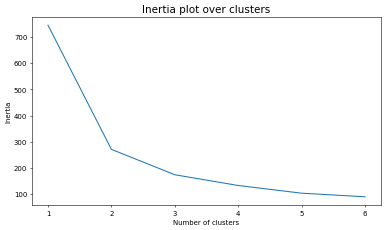

In [4]:
range_clusters = range(1, 7)

inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(cust_val)
    inertia.append(kmclust.inertia_)
    
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5300102013988877
For n_clusters = 3, the average silhouette_score is : 0.4417442624446007
For n_clusters = 4, the average silhouette_score is : 0.4312752457173184
For n_clusters = 5, the average silhouette_score is : 0.40513483872502815
For n_clusters = 6, the average silhouette_score is : 0.3634653769570179


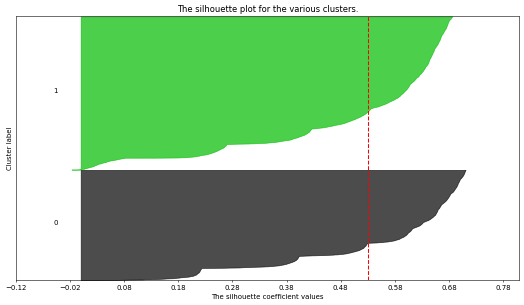

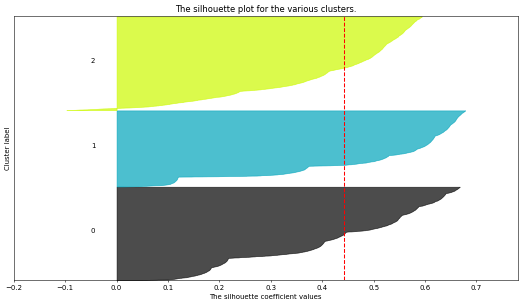

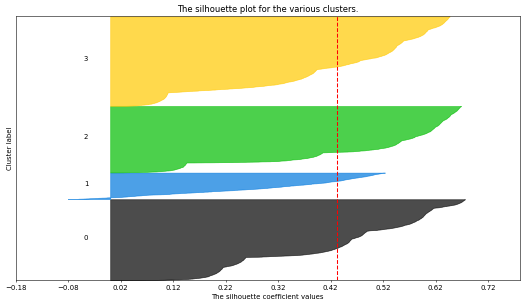

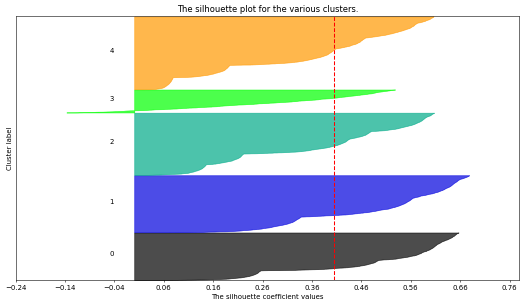

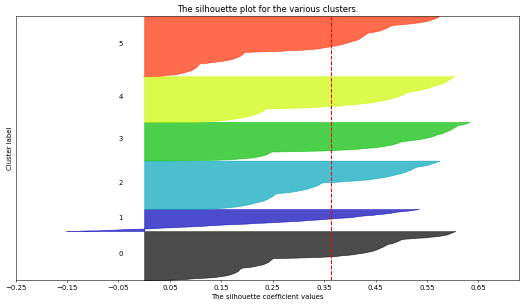

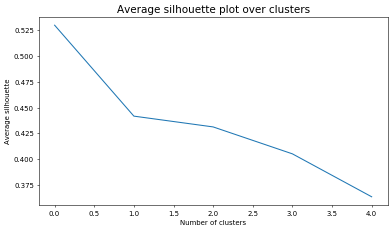

In [5]:
avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue
    
    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(cust_val)

    silhouette_avg = silhouette_score(cust_val, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(cust_val, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(cust_val) + (nclus + 1) * 10])
    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))


plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

* K-Means (init='random')

In [6]:
'''kmclust = KMeans(n_clusters=number_clusters, init='random', n_init=10, random_state=1)
kmclust.fit(cust_val)
kmclust.predict(cust_val)'''

"kmclust = KMeans(n_clusters=number_clusters, init='random', n_init=10, random_state=1)\nkmclust.fit(cust_val)\nkmclust.predict(cust_val)"

* K-Means++ (init='k-means++')

In [7]:
number_clusters = 2
kmclust1 = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels1 = kmclust1.fit_predict(cust_val)
km_labels1

array([0, 1, 1, ..., 1, 0, 1])

In [8]:
df_concat1 = pd.concat((cust_val, pd.Series(km_labels1, name='km_labels1',index=cust_val.index)), axis=1)
df_concat1.groupby('km_labels1').describe().T

km_labels1                     0            1
CustMonVal    count  4286.000000  5955.000000
              mean      0.889425     0.890648
              std       0.020750     0.021839
              min       0.000000     0.269271
              25%       0.876746     0.877137
              50%       0.888481     0.888722
              75%       0.901106     0.901480
              max       0.961327     1.000000
Client Tenure count  4286.000000  5955.000000
              mean      0.729281     0.294227
              std       0.133228     0.127293
              min       0.515385     0.000000
              25%       0.615385     0.192308
              50%       0.730769     0.307692
              75%       0.846154     0.384615
              max       1.000000     0.515385
Total Premium count  4286.000000  5955.000000
              mean      0.150227     0.186988
              std       0.071882     0.109574
              min       0.000000     0.006439
              25%       0.101220     0.112228
              50%       0.133661     0.153280
              75%       0.179125     0.229699
              max       0.546469     1.000000

In [9]:
df_ohc['cust_val'] = df_concat1['km_labels1']

### Perspective 2: Customer Demography

* Optimum number of clusters

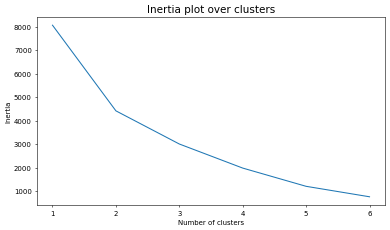

In [10]:
range_clusters = range(1, 7)

inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(demo)
    inertia.append(kmclust.inertia_)
    
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.4842587070744404
For n_clusters = 3, the average silhouette_score is : 0.5509840110909867
For n_clusters = 4, the average silhouette_score is : 0.6281714435417926
For n_clusters = 5, the average silhouette_score is : 0.7074742136491141
For n_clusters = 6, the average silhouette_score is : 0.7525524706475731


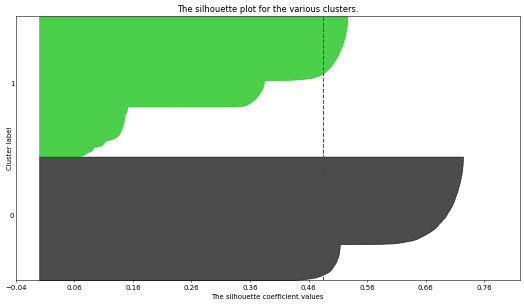

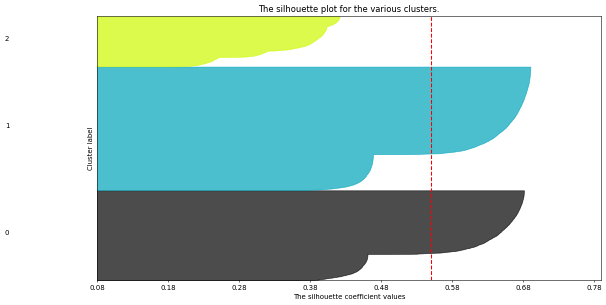

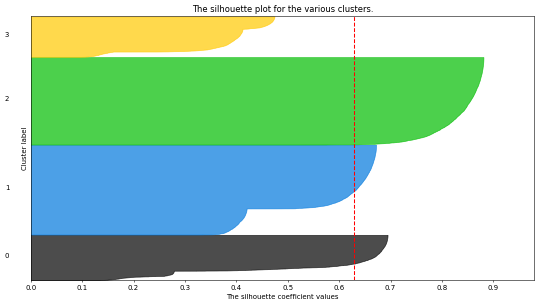

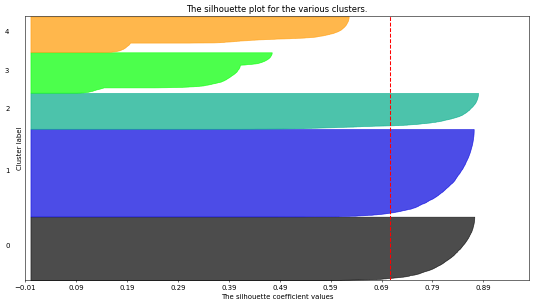

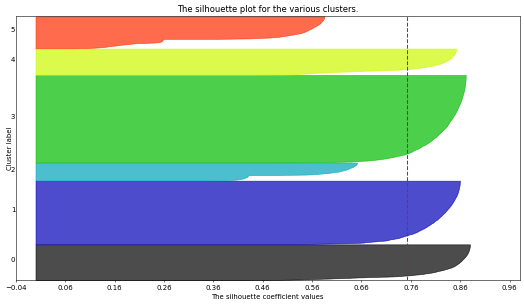

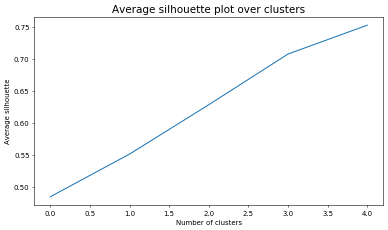

In [11]:
avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue
    
    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(demo)

    silhouette_avg = silhouette_score(demo, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(demo, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(cust_val) + (nclus + 1) * 10])
    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))


plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

* K-Means (init='random')

In [12]:
'''kmclust = KMeans(n_clusters=number_clusters, init='random', n_init=10, random_state=1)
kmclust.fit(demo)
kmclust.predict(demo)'''

"kmclust = KMeans(n_clusters=number_clusters, init='random', n_init=10, random_state=1)\nkmclust.fit(demo)\nkmclust.predict(demo)"

* K-Means++ (init='k-means++')

In [13]:
number_clusters = 5
kmclust2 = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels2 = kmclust2.fit_predict(demo)

In [14]:
df_concat2 = pd.concat((demo, pd.Series(km_labels2, name='km_labels2', index=demo.index)), axis=1)
df_concat2.groupby('km_labels2').describe().T

km_labels2                   0            1            2            3  \
High School count  2473.000000  3406.000000  1397.000000  1576.000000   
            mean      1.000000     0.000000     0.000000     0.000000   
            std       0.000000     0.000000     0.000000     0.000000   
            min       1.000000     0.000000     0.000000     0.000000   
            25%       1.000000     0.000000     0.000000     0.000000   
            50%       1.000000     0.000000     0.000000     0.000000   
            75%       1.000000     0.000000     0.000000     0.000000   
            max       1.000000     0.000000     0.000000     0.000000   
BSc/MSc     count  2473.000000  3406.000000  1397.000000  1576.000000   
            mean      0.000000     1.000000     1.000000     0.000000   
            std       0.000000     0.000000     0.000000     0.000000   
            min       0.000000     1.000000     1.000000     0.000000   
            25%       0.000000     1.000000     1.000000     0.000000   
            50%       0.000000     1.000000     1.000000     0.000000   
            75%       0.000000     1.000000     1.000000     0.000000   
            max       0.000000     1.000000     1.000000     0.000000   
PhD         count  2473.000000  3406.000000  1397.000000  1576.000000   
            mean      0.000000     0.000000     0.000000     0.442893   
            std       0.000000     0.000000     0.000000     0.496886   
            min       0.000000     0.000000     0.000000     0.000000   
            25%       0.000000     0.000000     0.000000     0.000000   
            50%       0.000000     0.000000     0.000000     0.000000   
            75%       0.000000     0.000000     0.000000     1.000000   
            max       0.000000     0.000000     0.000000     1.000000   
MonthSal    count  2473.000000  3406.000000  1397.000000  1576.000000   
            mean      0.399152     0.422108     0.646756     0.390204   
            std       0.175523     0.161937     0.174912     0.213091   
            min       0.000000     0.006826     0.010026     0.000000   
            25%       0.260666     0.301621     0.585751     0.212991   
            50%       0.395265     0.418089     0.687287     0.378946   
            75%       0.532423     0.542555     0.764078     0.551834   
            max       0.893985     0.970563     0.994454     0.915316   
Children    count  2473.000000  3406.000000  1397.000000  1576.000000   
            mean      0.999757     0.999824     0.000000     0.867766   
            std       0.006963     0.005934     0.000000     0.338102   
            min       0.800000     0.800000     0.000000     0.000000   
            25%       1.000000     1.000000     0.000000     1.000000   
            50%       1.000000     1.000000     0.000000     1.000000   
            75%       1.000000     1.000000     0.000000     1.000000   
            max       1.000000     1.000000     0.000000     1.000000   

km_labels2                   4  
High School count  1389.000000  
            mean      0.735781  
            std       0.441075  
            min       0.000000  
            25%       0.000000  
            50%       1.000000  
            75%       1.000000  
            max       1.000000  
BSc/MSc     count  1389.000000  
            mean      0.000000  
            std       0.000000  
            min       0.000000  
            25%       0.000000  
            50%       0.000000  
            75%       0.000000  
            max       0.000000  
PhD         count  1389.000000  
            mean      0.000000  
            std       0.000000  
            min       0.000000  
            25%       0.000000  
            50%       0.000000  
            75%       0.000000  
            max       0.000000  
MonthSal    count  1389.000000  
            mean      0.573181  
            std       0.240941  
            min       0.000213  
            25%       0.431314  
            50% 

In [15]:
df_ohc['demo'] = df_concat2['km_labels2']

## Evaluation

### Perspective 1: Customer Value

* Silhouette Score

In [16]:
def silhouette(X, algorithm):
    range_n_clusters = [2]
    silhouette_scores =[]
    
    for n_clusters in range_n_clusters:
        clusterer = algorithm(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
    return silhouette_scores

In [17]:
custval_km=df_concat1.copy()
custval_km['km_labels1'] = kmclust1.labels_

cluster0 = custval_km[custval_km.km_labels1==0]
cluster1 = custval_km[custval_km.km_labels1==1]
s_km1 = custval_km.iloc[:,1:-1].values

k_means_silhouette = silhouette(s_km1, KMeans)

For n_clusters = 2 The average silhouette_score is : 0.5334586589125839


* R^2

In [18]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss

In [19]:
sst = get_ss(cust_val) 
ssw_labels = df_concat1.groupby(by='km_labels1').apply(get_ss)  
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.6369


### Perspective 2: Customer Demography

* Silhouette Score

In [20]:
def silhouette(X, algorithm):
    range_n_clusters = [5]
    silhouette_scores =[]
    
    for n_clusters in range_n_clusters:
        clusterer = algorithm(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
    return silhouette_scores

In [21]:
demo_hc=df_concat2.copy()
demo_hc['km_labels2'] = kmclust2.labels_

cluster0 = demo_hc[demo_hc.km_labels2==0]
cluster1 = demo_hc[demo_hc.km_labels2==1]
cluster2 = demo_hc[demo_hc.km_labels2==2]
cluster3 = demo_hc[demo_hc.km_labels2==3]
cluster4 = demo_hc[demo_hc.km_labels2==4]

s_km2 = demo_hc.iloc[:,1:-1].values

k_means_silhouette = silhouette(s_km2, KMeans)

For n_clusters = 5 The average silhouette_score is : 0.7780757157845202


* R^2

In [22]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss

In [23]:
sst = get_ss(demo)  
ssw_labels = df_concat2.groupby(by='km_labels2').apply(get_ss)  
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.8513


## Cluster Visualization

In [25]:
from sklearn.manifold import TSNE

def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

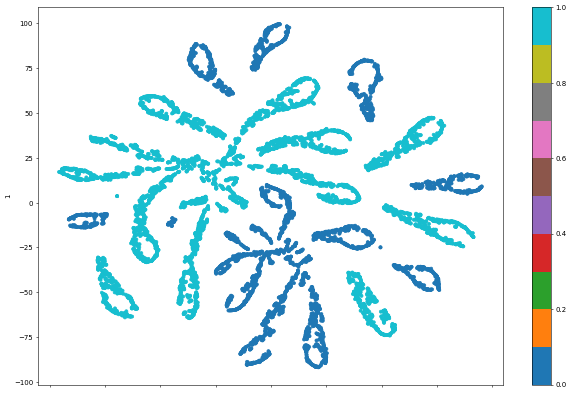

In [26]:
two_dim = TSNE(random_state=42).fit_transform(df_concat1)
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_concat1['km_labels1'], colormap='tab10', figsize=(15,10))
plt.show()